In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import NMF
from sklearn.metrics import precision_score, recall_score


np.random.seed(42) 

In [3]:
movies = pd.read_csv(r'C:\Users\sidha\Downloads\ml-latest\ml-latest-small\movies.csv')
links = pd.read_csv(r"C:\Users\sidha\Downloads\ml-latest\ml-latest-small\links.csv")
movies_df = pd.merge(links,movies,on = "movieId")
movies_df.drop(["movieId","imdbId"], inplace=True, axis=1)
movies_df.dropna(inplace=True)
movies_df["tmdbId"] = movies_df["tmdbId"].astype(int)
movies_df.head()

,tmdbId,title,genres
0,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,8844,Jumanji (1995),Adventure|Children|Fantasy
2,15602,Grumpier Old Men (1995),Comedy|Romance
3,31357,Waiting to Exhale (1995),Comedy|Drama|Romance
4,11862,Father of the Bride Part II (1995),Comedy


In [2]:
#reading the dataset 
df = pd.read_csv(r'C:\Users\sidha\Downloads\testRatings.csv')
df = df[["userId", "rating", "tmdbId"]]
df.head()

,userId,rating,tmdbId
0,1,4.0,862
1,5,4.0,862
2,7,4.5,862
3,15,2.5,862
4,17,4.5,862


In [4]:
ratings_df = df

In [5]:
# creating a surprise object

reader = Reader(rating_scale=(0.5, 5))
data   = Dataset.load_from_df(df[['userId','tmdbId','rating']], reader)
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [16]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 3):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
    print(rmse_algorithm)
  
  return rmse_algorithm

In [17]:
rmse_svd = rmse_vs_factors(SVD,data)

[0.8699670772541614]
[0.8699670772541614, 0.869234652493815]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338, 0.8687363791814233]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338, 0.8687363791814233, 0.869436115209351]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338, 0.8687363791814233, 0.869436115209351, 0.8698829336632518]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338, 0.8687363791814233, 0.869436115209351, 0.8698829336632518, 0.870149860046887]
[0.8699670772541614, 0.869234652493815, 0.8689796672542691, 0.8697371854309222, 0.8702894477134338, 0.8

In [18]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

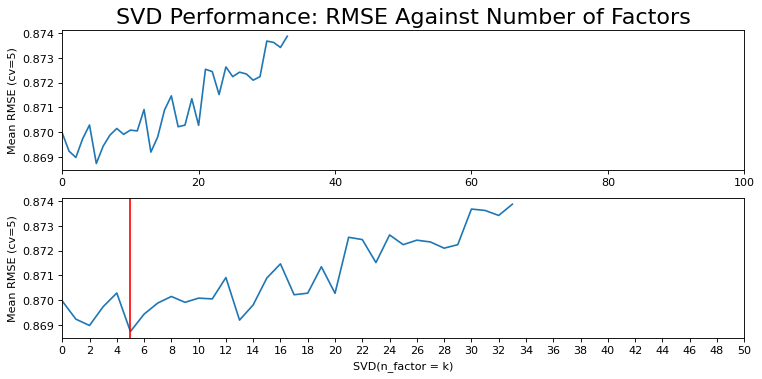

In [19]:
plot_rmse(rmse_svd,"SVD")


In [20]:
algo_SVD = SVD(n_factors = 11)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=1, iid=8844, r_ui=3.501636531347014, est=4.264106203846414, details={'was_impossible': False}),
 Prediction(uid=1, iid=31357, r_ui=3.501636531347014, est=3.7749352947932997, details={'was_impossible': False})]

In [21]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"tmdbId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'tmdbId', right_on = 'tmdbId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'tmdbId', right_on = 'tmdbId')
    
    
    return hist_usr, pred_usr

In [22]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)
hist_SVD_124.head(15)


User 124 has already rated 50 movies.


,userId,rating,tmdbId,title,genres
0,124,5.0,12498,Sling Blade (1996),Drama
1,124,5.0,641,Requiem for a Dream (2000),Drama
2,124,5.0,38,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,5.0,12,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,5.0,14,American Beauty (1999),Drama|Romance
5,124,5.0,13,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,5.0,275,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,4.5,9475,Scent of a Woman (1992),Drama
8,124,4.5,1892,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,4.5,1891,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [23]:
pred_SVD_124.head(15)

,userId,tmdbId,rat_pred,title,genres
0,124,550,4.616533,Fight Club (1999),Action|Crime|Drama|Thriller
1,124,935,4.609447,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
2,124,947,4.576517,Lawrence of Arabia (1962),Adventure|Drama|War
3,124,567,4.539685,Rear Window (1954),Mystery|Thriller
4,124,238,4.537797,"Godfather, The (1972)",Crime|Drama
5,124,240,4.533943,"Godfather: Part II, The (1974)",Crime|Drama
6,124,28,4.533805,Apocalypse Now (1979),Action|Drama|War
7,124,500,4.527756,Reservoir Dogs (1992),Crime|Mystery|Thriller
8,124,424,4.515353,Schindler's List (1993),Drama|War
9,124,289,4.512294,Casablanca (1942),Drama|Romance


In [24]:
rmse_nmf = rmse_vs_factors(NMF, data)


[1.231287016198695]
[1.231287016198695, 1.0476351799945716]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199, 0.9208555379950996]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199, 0.9208555379950996, 0.9182922496420922]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199, 0.9208555379950996, 0.9182922496420922, 0.9232825985947539]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199, 0.9208555379950996, 0.9182922496420922, 0.9232825985947539, 0.9283273501226532]
[1.231287016198695, 1.0476351799945716, 0.9690951351918315, 0.9386851830767554, 0.9233939174741199, 

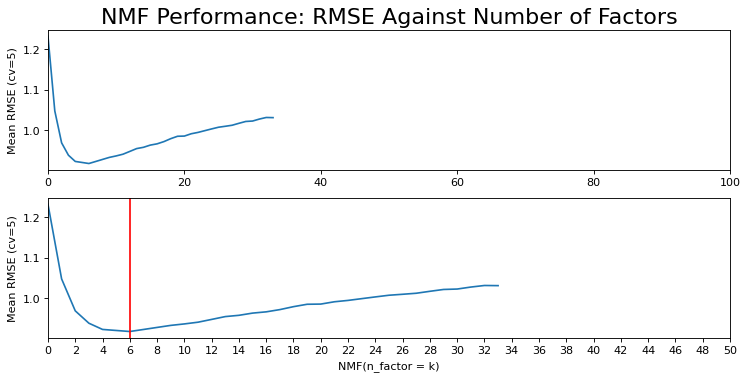

In [25]:
plot_rmse(rmse_nmf, "NMF")


In [26]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [28]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [35]:
pred_NMF_124.head(15)


,userId,tmdbId,rat_pred,title,genres
0,124,63076,5.0,Heidi Fleiss: Hollywood Madam (1995),Documentary
1,124,909,5.0,Meet Me in St. Louis (1944),Musical
2,124,4174,5.0,Spellbound (1945),Mystery|Romance|Thriller
3,124,10835,5.0,"Killer, The (Die xue shuang xiong) (1989)",Action|Crime|Drama|Thriller
4,124,490,5.0,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
5,124,1480,5.0,Touch of Evil (1958),Crime|Film-Noir|Thriller
6,124,28198,5.0,Vampire in Venice (Nosferatu a Venezia) (Nosfe...,Horror
7,124,12761,5.0,Autumn Sonata (Höstsonaten) (1978),Drama
8,124,13321,5.0,Lifeboat (1944),Drama|War
9,124,11167,5.0,Peeping Tom (1960),Drama|Horror|Thriller


In [42]:
from surprise.model_selection import KFold
from sklearn.metrics import precision_score, recall_score

# Set up the k-fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize lists to store precision and recall scores
precision_scores = []
recall_scores = []

# Iterate over the folds
for train_index, test_index in kf.split(data):
    trainset = data[train_index]
    testset = data[test_index]

    # Fit the SVD model on the training set
    algo = SVD(n_factors=11)
    algo.fit(trainset)

    # Make predictions on the test set
    predictions = algo.test(testset)

    # Extract the true ratings and predicted ratings for each user-item pair
    true_ratings = [pred.r_ui for pred in predictions]
    pred_ratings = [pred.est for pred in predictions]


    # Calculate precision and recall scores
    precision = precision_score(true_ratings, pred_ratings)
    recall = recall_score(true_ratings, pred_ratings)

    # Append scores to the lists
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate mean precision and recall scores across all folds
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)


TypeError: 'DatasetAutoFolds' object is not subscriptable